In [32]:
import cv2
import numpy as np
import pandas as pd
import math
from scipy import signal
from scipy.ndimage import convolve
from PIL import Image
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
base_path = "C:\\Users\\30len\\bakalarka\\eyetrackingdata\\eyetrackingdata\\fixdens\\Raw\\"
part_names = ['alex', 'analene', 'brian', 'brian2', 'dan', 'david', 'fu', 'henrik', 'jasmin','kcheng', 'mark', 'michelle', 'mike', 'mohamed', 'neil', 'roshanak', 'ryan', 'terry', 'xiao', 'zoreh']
#processed som nepouzila
sum_names = len(part_names)
pict_no = 1
name_counter = 0

#path = "C:\\Users\\30len\\bakalarka\\eyetrackingdata\\eyetrackingdata\\fixdens\\Raw\\brian\\1.fix"
#potrebujem poskladat cestu ako je uvedene vyssie, je potrebne ale menit meno a fixacie pre obrazky

### Načítanie súboru s fixáciami
- vráti riadky


In [34]:
def load_file(path):
    with open(path, "r") as file:  # Use file to refer to the file object
        data = file.read()
        rows = data.split("\n")
    return rows

### Zistenie počtu fixácií v danom súbore
- vráti počet

In [35]:
def count_fixations(rows):
    fix_count = 0
    if "No fixations!" not in rows[8]:
        count = re.search("\d+", rows[8])
        fix_count = int(count.group(0))
    return fix_count

### Prepočítanie hodnôt všetkých fixácií v jednom súbore + zapísanie do dataframu
- vráti dataframe jedného súboru (fixácií jedného participanta, pre jeden obrázok)

In [36]:
def ret_df_fix(rows, hodnota, df_fix, part_index):
    counter = 1
    nazov = "fix_"
    nova_fix = ""
    x = []
    y = []
    
    for index, row in enumerate(rows):
        if ((index >=12) and (index < (12 + hodnota))):
            #iba riadky s fixaciami
            match_fix = re.findall(r'\d+', row)
            x_pos = int(match_fix[1])
            y_pos = int(match_fix[2])
            if ((x_pos > 1024) or (x_pos < 0) or (y_pos > 768) or (y_pos < 0)): #hodnoty mimo obraz
                vysledok = -1
            else:
                x.append(x_pos)
                y.append(y_pos)
                vysledok = x_pos * 1024 + y_pos
            nova_fix = nazov + str(counter)
            counter = counter + 1
#             print("nova fixacia nazov", nova_fix, "counter", counter)
            if nova_fix not in df_fix:
#                 df_fix[nova_fix] = np.nan 
                df_fix[nova_fix] = -1
            df_fix.loc[part_index][nova_fix] = vysledok
    
#     print("fix_count", fix_count, "participant index ", part_index)
    plt.ylim(0, 768)
    plt.xlim(0, 1024)
    plt.scatter(x, y)
    plt.title("participant cislo " + str(part_index))
    plt.show()
    return df_fix

nasledujúca časť by možno pomohla pri určovaní, aký počet fixácií si ponecháme a nad nimi budeme ďalej pracovať v k-means. Potrebné ešte vyriešiť - akým spôsobom určíte počet fixácií na ponechanie? (chceme max. počet fixácií na úkor malého počtu participantov...alebo chceme väčší počet participantov na úkor menšieho počtu fixácií???)

In [37]:
# new_arr = sorted(set(d['df_fix_1']['fixation_count']))
# if (min(new_arr) == 0):
#     new_arr.remove(0)
# new_arr

### Vytvorenie kompletného datasetu, s ktorým sa bude dať pracovať  v k-means
- momentálne nastavené vo vonkajšom for cykle range(1)- čiže iba jeden obrázok, potom použiť 120,  pre všetky obrázky
- potrebné zakomponovať kód na určenie počtu fixácií, ktorý si chceme ponechať, ako bolo spomenutí vyššie - momentálne to určruje premenná "nahradit_hodnotou" = 4, čiže nastavené na 4 fixácie
- potrebné vyriešiť dropnutie riadkov, kde sú ešte hodnoty fixácií -1, kvôli fixácii mimo obraz (alebo to riešiť nejako inak??)

df_fix_1


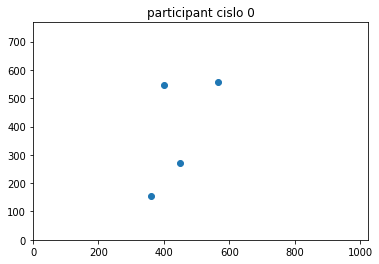

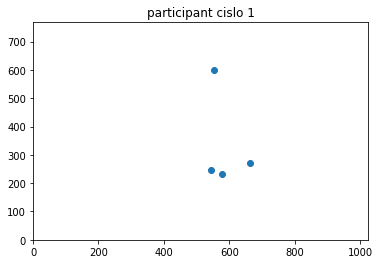

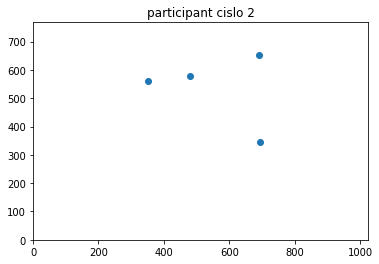

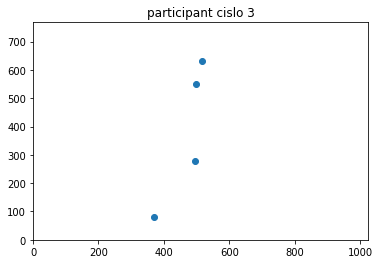

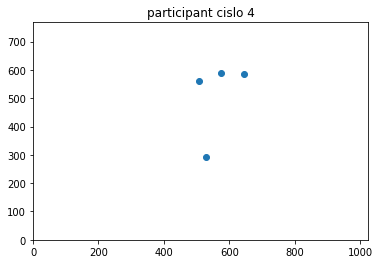

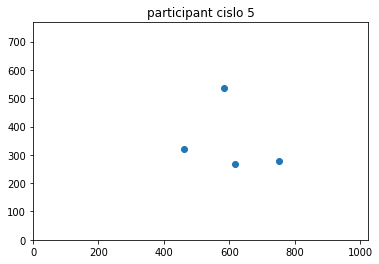

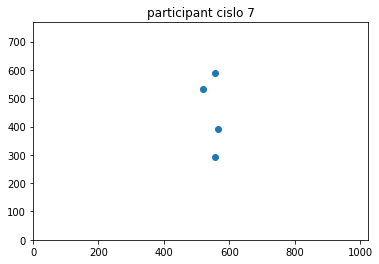

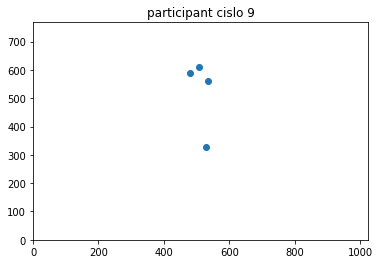

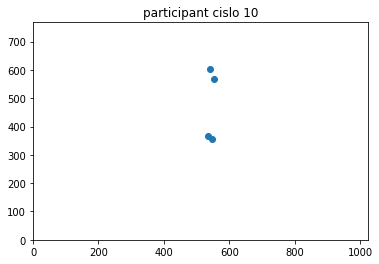

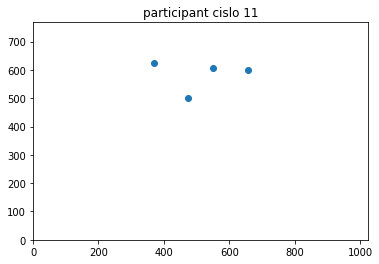

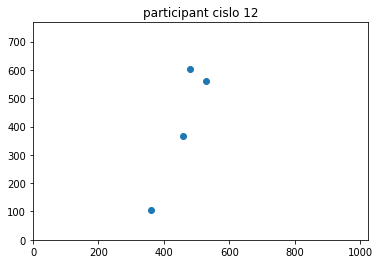

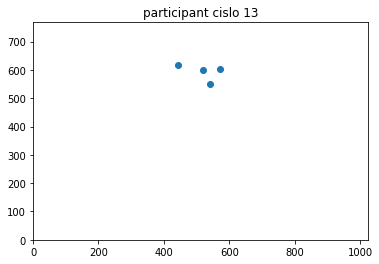

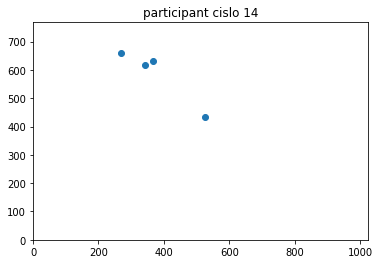

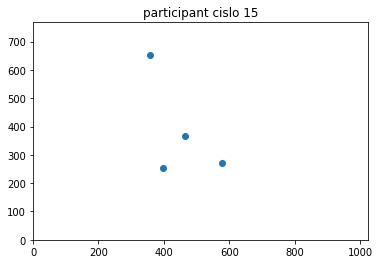

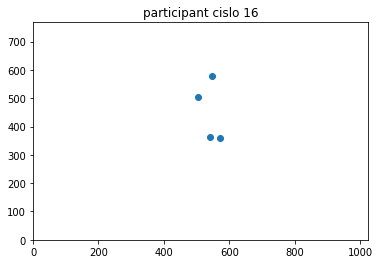

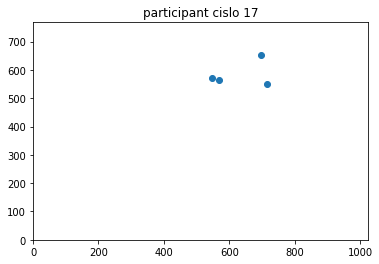

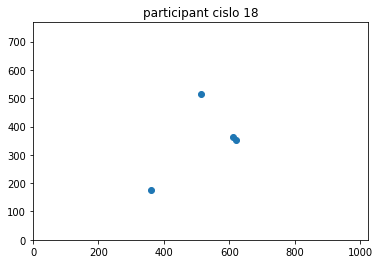

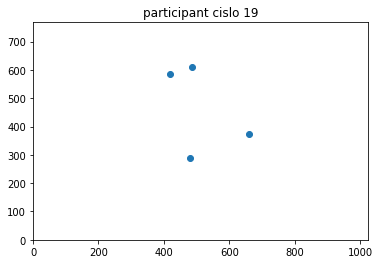

,fix_1,fix_2,fix_3,fix_4
0,460046,369820,580140,410148
1,558326,566871,593128,678160
2,492099,361010,708235,711001
3,508184,511528,530038,378961
4,541990,519729,662090,590413
5,473407,597527,632075,770328
7,569638,580998,533014,568908
9,542023,493134,518754,549426
10,547183,565816,554586,560485
11,486902,563806,674392,379504


In [38]:
zakladny_nazov = "df_fix_"
d = {}
    
for index in range(1): #normalne bude range po 120, lebo mame 120 obrazkov
    print(zakladny_nazov + str(index+1))
    novy_nazov = zakladny_nazov + str(index+1)
    d[novy_nazov] = pd.DataFrame(index=range(0, sum_names))
    nazov = "fix_1"
    d[novy_nazov][nazov] = -1

    fix_count_arr = []
#     tuto treba urobit magic, kolko fixacii budem chciet
    nahradit_hodnotou = 4
    
    for index_2, name in enumerate(part_names):
        path = base_path + part_names[index_2] + "\\" + str(index+1) + ".fix"
        rows = load_file(path)
        fix_count = count_fixations(rows)
        fix_count_arr.append(fix_count)
        
        #magic, kolko fixacii chcem v dataframe by mal byt tu!
        
    for index_3, fix in enumerate(fix_count_arr):
        if (fix >= nahradit_hodnotou):
            path = base_path + part_names[index_3] + "\\" + str(index+1) + ".fix"
            rows = load_file(path)
            d[novy_nazov] = ret_df_fix(rows, nahradit_hodnotou, d[novy_nazov], index_3)
        
#     d[novy_nazov]['fixation_count'][index_2] = fix_count
#       print(d[novy_nazov]['fixation_count'][index_2])

# Get names of indexes for which column .. has value -1
indexNames = d['df_fix_1'][ d['df_fix_1']['fix_4'] == -1 ].index #este osetrit, v podstate kdekolvek moze byt -1, ak je fixacia mimo obraz
# print(indexNames)
# Delete these row indexes from dataFrame
d['df_fix_1'].drop(indexNames , inplace=True)
d['df_fix_1']
# fix_count_arr

## Tu sa začína klasicky k-means
Nastavené
- použijú sa všetky fixácie v dataframe
- pretypovanie na float32
- kritériá - 2 clustre, max.iter 10, epsilon 1,0
- označenie clustrov labelami 0,1

In [39]:
arr = d['df_fix_1'].as_matrix(columns=d['df_fix_1'].columns[:])
Z = np.vstack(arr)
Z

C:\Users\30len\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[460046, 369820, 580140, 410148],
       [558326, 566871, 593128, 678160],
       [492099, 361010, 708235, 711001],
       [508184, 511528, 530038, 378961],
       [541990, 519729, 662090, 590413],
       [473407, 597527, 632075, 770328],
       [569638, 580998, 533014, 568908],
       [542023, 493134, 518754, 549426],
       [547183, 565816, 554586, 560485],
       [486902, 563806, 674392, 379504],
       [471408, 542258, 493148, 368745],
       [554533, 454251, 533080, 587355],
       [540082, 376438, 349800, 277140],
       [476527, 368270, 405759, 592142],
       [559683, 587112, 555370, 515577],
       [560699, 715406, 731687, 583222],
       [526850, 635231, 369840, 626028],
       [428616, 498275, 675188, 492833]], dtype=int64)

In [40]:
# convert to np.float32
Z = np.float32(Z)

In [41]:
# define criteria and apply kmeans()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

In [42]:
ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

In [43]:
# Now separate the data, Note the flatten()
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
label

array([[1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

In [44]:
# d['df_fix_1']['fix_1']

#### Spätné vypočítanie fixácií a pridanie do poľa x a y
- aby sme to mohli použiť pri zobrazení v grafe

In [45]:
x = []
y = []

for i in range(4):
    for index, value in enumerate(d['df_fix_1']['fix_'+str(i+1)]):
        temp_fix = value #vypocitanie spatne suradnic x a y
        temp_x = int(temp_fix / 1024)
        temp_y = temp_fix % 1024
        x.append(temp_x)
        y.append(temp_y)


In [46]:
# upravenie labelov, aby sa s nimi dalo pracovat
# print(x)
# print(y)
array = label.flatten()
array = array.tolist()
array = array *4  # to, koľkokrát sa pole prenásobí závisí od toho, koľko fixácií sa použilo - aby sme vedeli namapovať k fixáciám label
# array

#### Zobrazenie konkrétnych fixácií s farebným rozlíšením pre zhluky
- v tomto prípade nám ostalo 18 participantov, každý má 4 fixácie, to znamená, že by v grafe malo byť 18*4 fixácií, spolu s ich zaradením do zhluku (podľa farby)

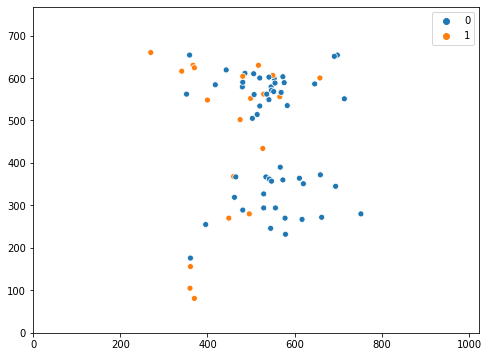

In [47]:
plt.figure(figsize=(8,6))
plt.ylim(0, 768)
plt.xlim(0, 1024)
sns.scatterplot(x, y, hue=array)

### Skúška- zobrazenie na boxplote 
- hodnoty ktoré som vytvárala spôsobom **x_pos * 1024 + y_pos** a ktoré vstupovali do k-means
**Tuto je vidieť veľký rozdiel - na boxplote je to viac menej dobre viditeľné, ale vyššie uvedený scatter plot s konkrétnymi fixáciami nevykazuje nejaké "pekné" zaradenia**

In [48]:
hodnoty = []

for i in range(4):
    for index, value in enumerate(d['df_fix_1']['fix_'+str(i+1)]):
        hodnoty.append(value)

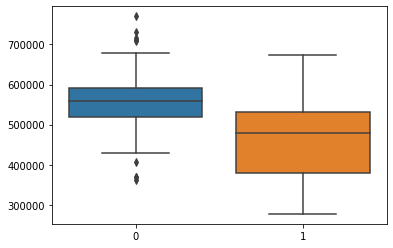

In [49]:
sns.boxplot(x=array, y=hodnoty)